In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import time
import copy
from tqdm.notebook import tqdm

In [2]:
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = efficientnet_v2_l(EfficientNet_V2_L_Weights)

num_classes = len(classes)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
)

model = model.to('cuda')

/home/abr1/anaconda3/envs/term_project/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/abr1/anaconda3/envs/term_project/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              SiLU-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           9,216
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              SiLU-6           [-1, 32, 16, 16]               0
   StochasticDepth-7           [-1, 32, 16, 16]               0
       FusedMBConv-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             SiLU-11           [-1, 32, 16, 16]               0
  StochasticDepth-12           [-1, 32, 16, 16]               0
      FusedMBConv-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1, 32,

In [6]:
## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = trainloader
dataloaders['test'] = testloader

batch_num['train'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['test'])

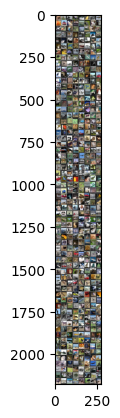

horse bird  car   car   bird  cat   truck plane bird  car   dog   car   ship  frog  dog   dog   plane deer  bird  deer  ship  horse dog   frog  truck dog   dog   frog  truck car   plane deer  truck ship  cat   cat   truck truck deer  plane frog  plane plane frog  ship  car   car   car   deer  frog  car   plane cat   deer  cat   bird  bird  horse dog   ship  cat   plane truck bird  car   deer  plane dog   frog  dog   cat   bird  deer  truck cat   deer  car   deer  bird  bird  plane frog  bird  horse horse deer  ship  car   truck horse cat   horse dog   cat   truck frog  car   plane deer  horse car   plane dog   frog  dog   deer  cat   bird  plane ship  frog  dog   deer  ship  cat   deer  horse truck frog  cat   horse horse ship  cat   dog   dog   truck truck horse ship  cat   bird  truck ship  frog  dog   cat   truck ship  car   truck deer  frog  deer  frog  deer  bird  bird  truck frog  dog   horse frog  frog  deer  deer  car   bird  frog  ship  plane bird  dog   frog  ship  bird  hors

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(trainset[0][0].shape)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

epoch = 350

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), 
                         lr = 1e-4,
                         momentum=0.9,
                         weight_decay=1e-5)

exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in tqdm(range(num_epochs)):

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(phase, epoch_loss, epoch_acc))
           
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

In [ ]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(
    model, criterion, optimizer, exp_lr_scheduler, num_epochs=epoch)

  0%|          | 0/350 [00:00<?, ?it/s]

train Loss: 2.58 Acc: 10.6
test Loss: 2.36 Acc: 12.0
==> best model saved - 0 / 12.0
train Loss: 2.49 Acc: 12.2
test Loss: 2.30 Acc: 14.6
==> best model saved - 1 / 14.6
train Loss: 2.41 Acc: 13.9
test Loss: 2.25 Acc: 16.9
==> best model saved - 2 / 16.9
train Loss: 2.35 Acc: 15.0
test Loss: 2.20 Acc: 18.9
==> best model saved - 3 / 18.9
train Loss: 2.31 Acc: 16.3
test Loss: 2.16 Acc: 21.2
==> best model saved - 4 / 21.2
train Loss: 2.27 Acc: 17.8
test Loss: 2.12 Acc: 22.9
==> best model saved - 5 / 22.9
train Loss: 2.22 Acc: 19.1
test Loss: 2.07 Acc: 24.7
==> best model saved - 6 / 24.7
train Loss: 2.19 Acc: 20.1
test Loss: 2.04 Acc: 26.3
==> best model saved - 7 / 26.3
train Loss: 2.17 Acc: 21.3
test Loss: 2.01 Acc: 27.8
==> best model saved - 8 / 27.8
train Loss: 2.13 Acc: 22.4
test Loss: 1.98 Acc: 29.2
==> best model saved - 9 / 29.2
train Loss: 2.10 Acc: 23.6
test Loss: 1.95 Acc: 30.2
==> best model saved - 10 / 30.2
train Loss: 2.07 Acc: 24.8
test Loss: 1.92 Acc: 31.2
==> best mo

In [ ]:
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-', label='train acc')
ax1.plot(valid_acc, 'r-', label='train acc')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()

ax2.plot(train_loss, 'g-', label='train loss')
ax2.plot(valid_loss, 'k-', label='valid loss')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
ax2.legend(loc='lower right')
ax1.legend(loc='upper right')
plt.show()